<a href="https://colab.research.google.com/github/Rajeeb321123/Deep-learning-tensorFlow-Journey/blob/master/06_transfer_learning_in_tensorflow_part3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Leraning with TensorFlow Part 3: Scaling up (🍔👁️ Food Vision mini)


We've  seen the power of transfer learning features extraction and fine-tunnnig, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

OUr baseline is to beat 50.71% accuracy accross 101 class.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Sun Mar 31 12:36:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating Hepler Functions

In previous notebooks, We create various functions to assist us to different task. Let's download them

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-31 12:36:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-31 12:36:04 (93.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of hepler functionsj in our note book
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-03-31 12:36:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   155MB/s    in 8.6s    

2024-03-31 12:36:17 (180 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
# How many image/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE =(224, 224)

In [9]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10 % of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentaion layer to build data augmentaion right into the model
* Build a headless (no top layers) functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full classes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)
                                                                              

In [10]:
# Create checkpoint callback
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy", # check for val_accuracy
                                                         save_best_only=True) # save only with highest val_accuracy

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [ ]:
# Setup data augmentaion
data_augmentaion = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 and 1, required for models like ResNet50
], name = "data_augmentaion")

In [ ]:
# Setup the base model and freeze it's layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # mean we dont want output neurons
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name = "input_layer")
x = data_augmentaion(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put these model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x) # 2D because we are working with 2D images
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentaion (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)), # validate on only 15% of data during training,
                                           callbacks=[checkpoint_callback]
                                           )

Epoch 1/5
237/237 [==============================] - 158s 622ms/step - loss: 3.3678 - accuracy: 0.2730 - val_loss: 2.5471 - val_accuracy: 0.4303
Epoch 2/5
237/237 [==============================] - 111s 462ms/step - loss: 2.1918 - accuracy: 0.4978 - val_loss: 2.1380 - val_accuracy: 0.4801
Epoch 3/5
237/237 [==============================] - 92s 388ms/step - loss: 1.8278 - accuracy: 0.5628 - val_loss: 1.9658 - val_accuracy: 0.5013
Epoch 4/5
237/237 [==============================] - 81s 339ms/step - loss: 1.6074 - accuracy: 0.6117 - val_loss: 1.8751 - val_accuracy: 0.5132
Epoch 5/5
237/237 [==============================] - 73s 306ms/step - loss: 1.4624 - accuracy: 0.6380 - val_loss: 1.8356 - val_accuracy: 0.5212


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results
#790/790 [==============================] - 57s 72ms/step - loss: 1.5835 - accuracy: 0.5839
#[1.5835423469543457, 0.5838811993598938]

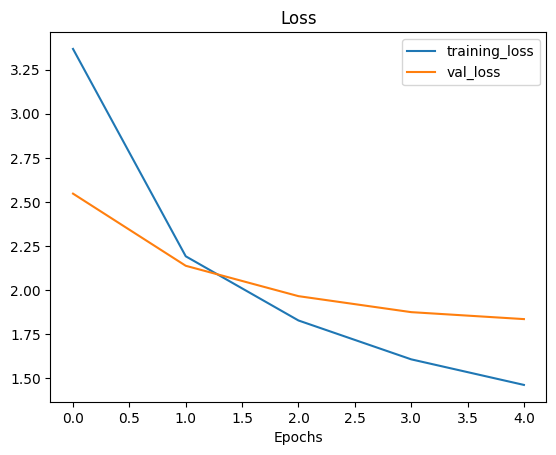

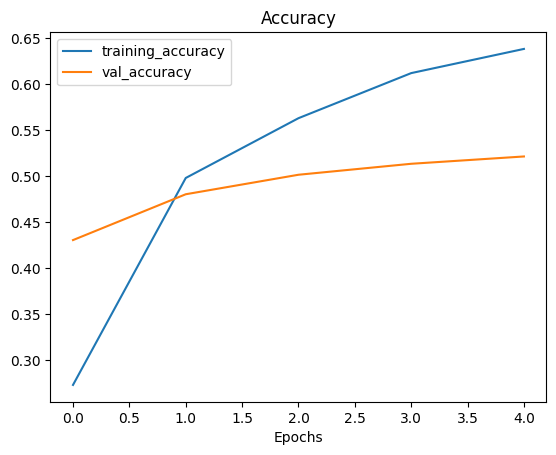

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not...

If not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5 (only 5 because our feature extractor is doing pretty well)
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate while fine-tunning)
model.compile(loss="categorical_entropy",
              optimizer = tf.keras.optimizer.Adam(learning_Rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentaion True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                    epochs=fine_tune_epochs, # 5 epochs has already been done, here only 5 epochs
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    initial_epoch=history_all_classes_10_percent.epoch[-1]) # We start at 5 epochs as we already did 5 epochs in feature extraction

Epoch 5/10
237/237 [==============================] - 74s 312ms/step - loss: 1.3368 - accuracy: 0.6661 - val_loss: 1.7887 - val_accuracy: 0.5283
Epoch 6/10
237/237 [==============================] - 70s 293ms/step - loss: 1.2363 - accuracy: 0.6948 - val_loss: 1.7560 - val_accuracy: 0.5373
Epoch 7/10
237/237 [==============================] - 64s 267ms/step - loss: 1.1382 - accuracy: 0.7189 - val_loss: 1.7610 - val_accuracy: 0.5371
Epoch 8/10
237/237 [==============================] - 57s 240ms/step - loss: 1.0765 - accuracy: 0.7360 - val_loss: 1.7732 - val_accuracy: 0.5310
Epoch 9/10
237/237 [==============================] - 58s 241ms/step - loss: 1.0151 - accuracy: 0.7526 - val_loss: 1.7737 - val_accuracy: 0.5373
Epoch 10/10
237/237 [==============================] - 56s 235ms/step - loss: 0.9508 - accuracy: 0.7667 - val_loss: 1.7524 - val_accuracy: 0.5418


In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.4974 - accuracy: 0.6006


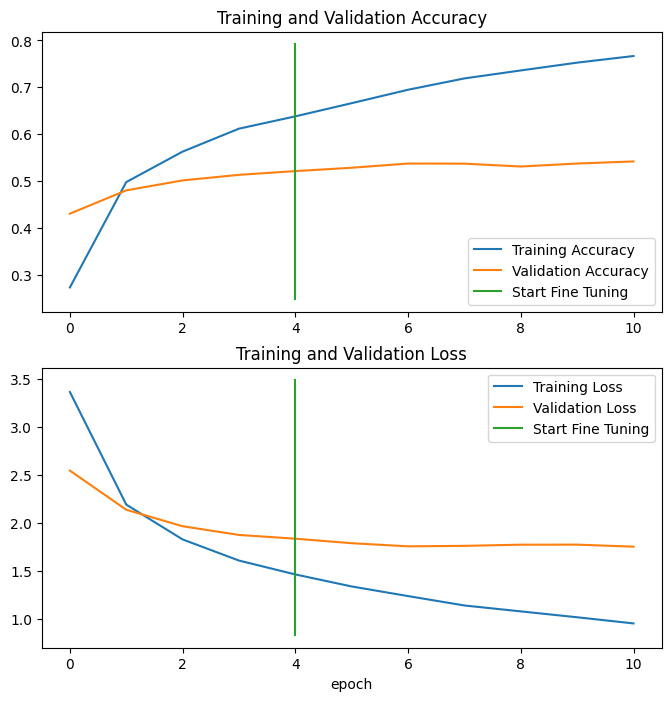

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and loading our model

To use our model in an external applicaiton, we'll need to save it and export somewhere

In [ ]:
# Save our fine-tunning model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model and compare performance of pre-saved model
loaded_model_results =loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 63s 78ms/step - loss: 1.4974 - accuracy: 0.6006


In [ ]:
# The results from our loaded model above should be very similar to results below
print(f"loaded_model:results:{loaded_model_results} \n all_classes_10_percent_fine_tune_results: {all_classes_10_percent_fine_tune_results}")

loaded_model:results:[1.4974035024642944, 0.6006336808204651] 
 all_classes_10_percent_fine_tune_results: [1.4974035024642944, 0.6006336808204651]


## Evaluating the performance of the big dog model across all different classes

Let's make some predictions visualize them and then later find out which predictions were the **"most wrong"**.

In [12]:
import tensorflow as tf

# Download the pretrained model (one that was prepared earlier, so all prediction are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-03-31 12:36:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   180MB/s    in 0.2s    

2024-03-31 12:36:48 (180 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [13]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [14]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [15]:
# Evalute the loaded model (the one we just downloaded on test data)
results_download_model = model.evaluate(test_data)
results_download_model

790/790 [==============================] - 62s 72ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making prediction with our trained model

In [16]:
# Make Prediction with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 64s 79ms/step


In [17]:
len(test_data) # 790 batches

790

In [18]:
# How many predictionare there? # one prediction for each test data
len(preds_probs)

25250

In [19]:
# what's the shape of predictions?
preds_probs.shape # output is 101  classes

(25250, 101)

In [20]:
# let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [21]:
# What does the first predictions array look like?
preds_probs[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [22]:
len(preds_probs[0])

101

In [23]:
sum(preds_probs[0]) # for each prediction total sum should be 1 or very very very near to 1. Hights value among 101 value is corresponds to prediction for belong to which class

0.9999999913078492

Our model ouputs a prediction probability array (with N number of variables, where N is the number of classes for each sample passed to the predict method).

In [24]:
# we get one prediction probability per each class ( in our case there's a 101 predictions probabilities)
print(f"Number of prediction probabilities for smaple 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()} with is class '{test_data.class_names[preds_probs[0].argmax()]}'")

Number of prediction probabilities for smaple 0: 101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-

In [25]:
# Get the pred classes for each label
pred_classes = preds_probs.argmax(axis=1) # Return indices of the maximum values along the given axis

# How do they look? for first 10 predictions
pred_classes[:10]


array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [26]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels

In [27]:
test_data # currently our test_data are in batches with diven shape

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [28]:
# To get our test Labels we need to unravel/unbatch our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch(): # unbatch our test_data
  y_labels.append(labels.numpy().argmax())

y_labels[:10] # let's look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluate our mode's predictions

One way to check model's predcitions array is in the same order as our test labels array is to find the accuracy score.

In [29]:
results_download_model # second value is accuracys

[1.8027204275131226, 0.6077623963356018]

In [30]:
# Let's try scikit learn accuracy score functions and see waht is come up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

sklearn_accuracy # same as our value in results_download_model

0.6077623762376237

In [31]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_download_model[1], sklearn_accuracy)

True

## Let's get Visual: Making a Confusion matrix

In [32]:
from helper_functions import make_confusion_matrix # we have already created function to create confusion matrix

In [33]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [36]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100, 100),
                      text_size = 20)

In [40]:
# We need to make some changes to our make_confusion_matrix function to ensure the x-labes print vertically

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Change (plot x-labels vertically)
  plt.xticks(rotation = 90, fontsize=text_size)
  plt.yticks( fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [44]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100, 100),
                      text_size = 20,
                      savefig = True)

## Let's keep the evaluation train going, time for a classificaiton report

Scikit-learn has a helpful function for accquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [45]:
from sklearn.metrics import classification_report

print(classification_report( y_true = y_labels, y_pred = pred_classes ))

#Precision = less false positive
#Recall = high leads to less false negative
#F1-score = combination of Precision and Recall

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.model

How about we create a visualization to get a better understanding?

In [47]:
# Get a dictionary of classification report

classification_report_dic = classification_report(y_true =y_labels,
                                                  y_pred = pred_classes,
                                                  output_dict = True # if true return output as dictionary
                                                  )

classification_report_dic

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [49]:
type(classification_report_dic)

dict

In [59]:
classification_report_dic["99"]

{'precision': 0.5193798449612403,
 'recall': 0.268,
 'f1-score': 0.35356200527704484,
 'support': 250}

In [60]:
classification_report_dic["99"]["f1-score"]

0.35356200527704484

Let's plot all of our classes F1-score...

In [61]:
class_f1_scores = {}
# Loop through classification report dictionary items

for k, v in classification_report_dic.items():
  if (k == 'accuracy'): #  key turn to accuracy we need to stop at the end. we dont want it
    break
  else:
    # Add class names and f1-scores to new dictionary class_f1_scores
    # class_names[int(k)] or class_names[0] = 'apple_pie'
    class_f1_scores[class_names[int(k)]] = v["f1-score"] # we want k as int. what we are doing here is similar to classification_report_dic["99"]["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [68]:
# True f1-score into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                         'f1-score': list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)

In [69]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

In [70]:
f1_scores[-10:]

class_names  f1-score
96             tacos  0.380952
15           ceviche  0.367442
99      tuna_tartare  0.353562
82           ravioli  0.342857
93             steak  0.342342
56  huevos_rancheros  0.339833
22  chocolate_mousse  0.329159
77         pork_chop  0.308756
39         foie_gras  0.297491
0          apple_pie  0.240566

In [79]:
 f1_scores["f1-score"].values # just to return all value

33    0.937143
63    0.895397
75    0.866538
91    0.847656
69    0.834008
        ...   
56    0.339833
22    0.329159
77    0.308756
39    0.297491
0     0.240566
Name: f1-score, Length: 101, dtype: float64

In [76]:
range(len(f1_scores))

range(0, 101)

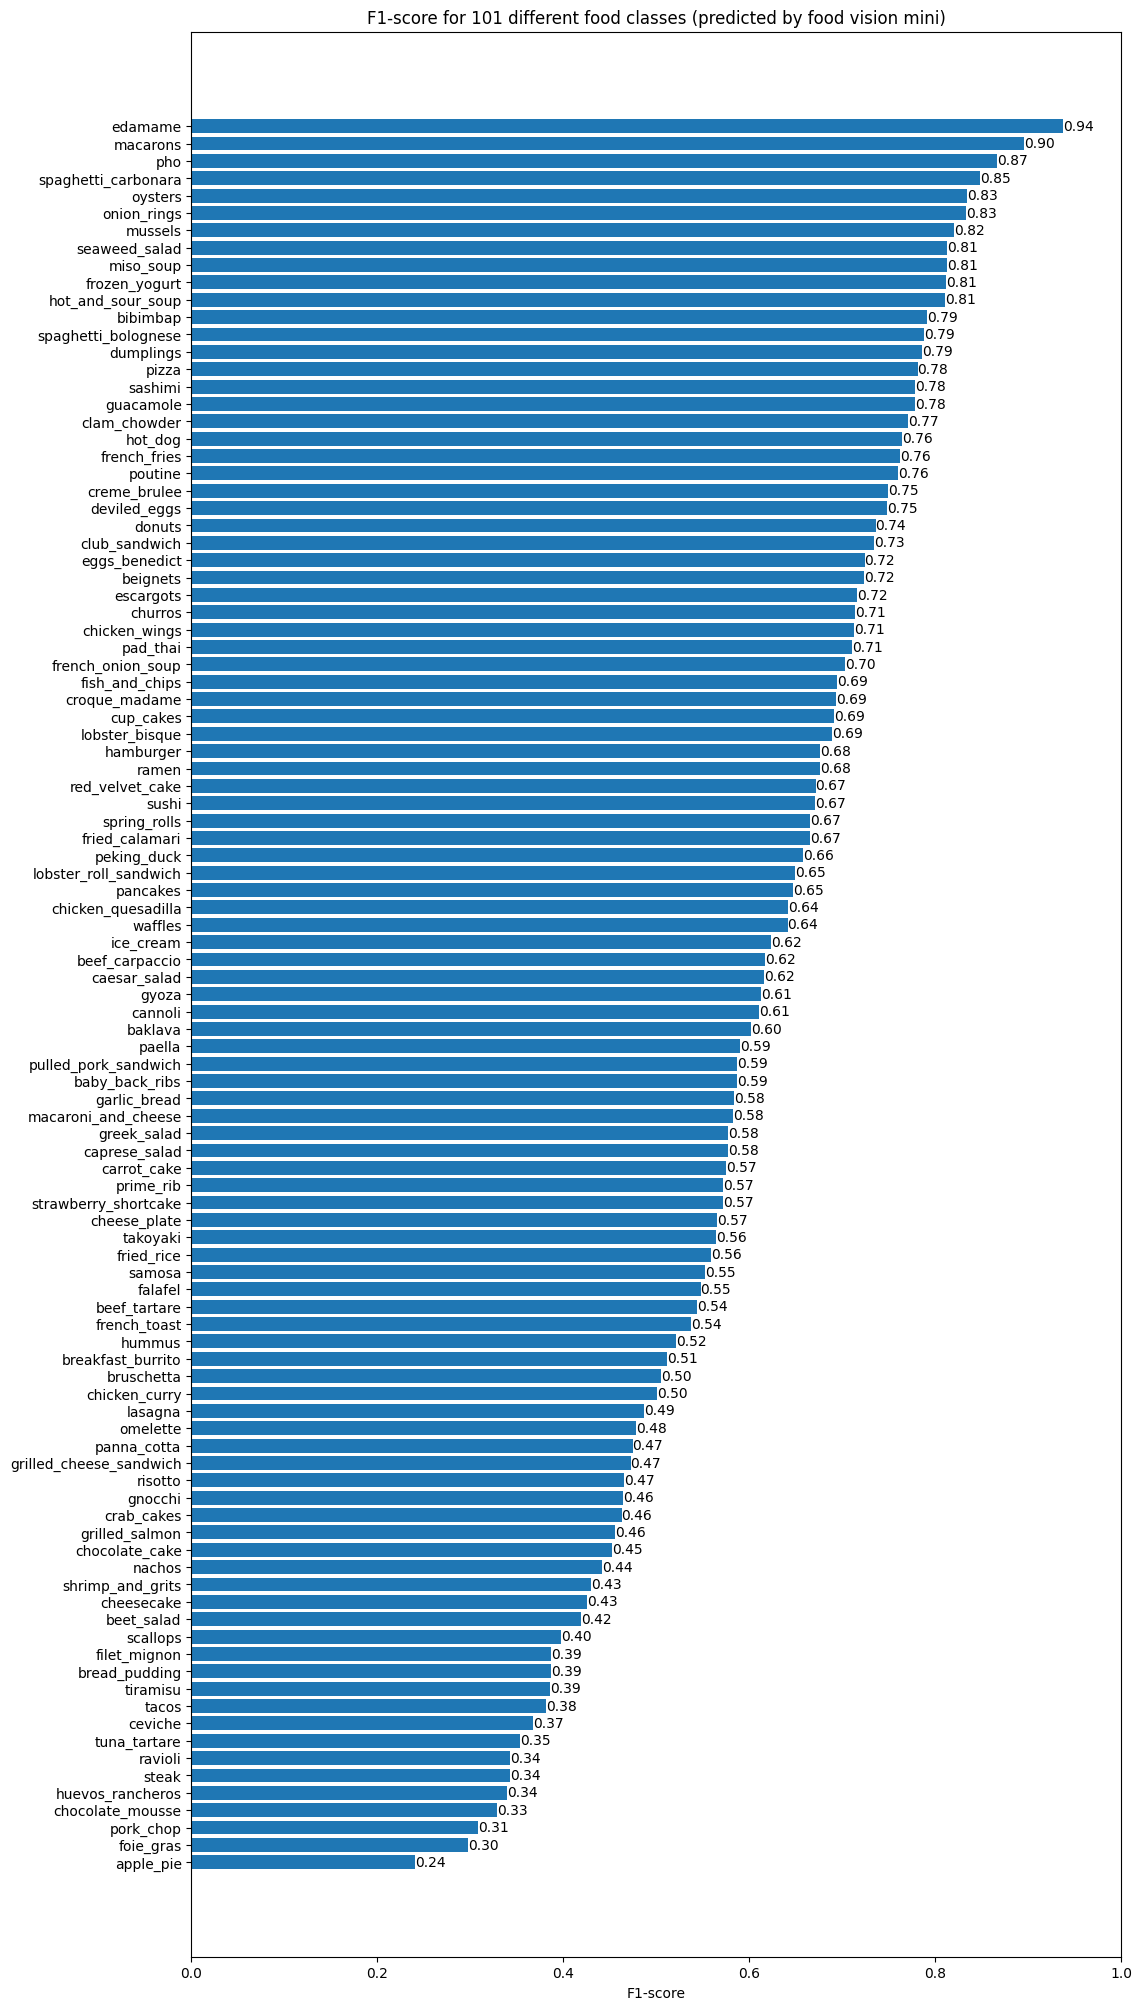

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 25))
# barh = bar graph
# f1_scores["f1-scores"].values return all the values
scores =  ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)

# we want the classnames
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])

ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 different food classes (predicted by food vision mini)")

# value at the end of each bar
# Label with specially formatted floats
ax.bar_label(scores, fmt='%.2f')
ax.set_xlim(right=1)  # adjust xlim to fit labels

# we want to invert for better visualizaion for descending order
ax.invert_yaxis()  # reverse the order of plot

⚒️ Try visualizing some of the most poorly predicted classes (eg: apple_pie, pork_chop), do you notice any trends among them? why might our model be having trouble with them?